Testing whether including the errorbars actually makes a difference...

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import corner
import emcee

In [4]:
def model(pars, x):
    return pars[0] * x + pars[1]

In [5]:
def lnprior(pars):
    if -10 < pars[0] < 10 and -10 < pars[1] < 10 and -10 < pars[2] < 10:
        return 0.
    else:
        return -np.inf

In [6]:
def lnprob(pars, x, y, yerr):
    return lnprior(pars) + lnlike(pars, x, y, yerr)

In [7]:
def lnlike(pars, x, y, yerr):
    invsig2 = 1./(yerr**2 + np.exp(2*pars[2]))
    model_y = model(pars, x)
    return -.5*np.sum((y-model_y)**2*invsig2 - np.log(invsig2))

params =  -0.525509606298 2.88909102256


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


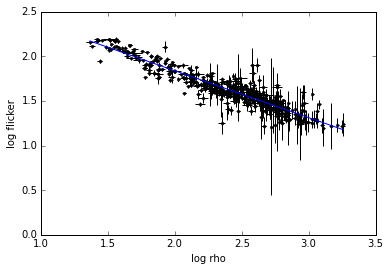

In [8]:
# load data
f, ferr, r, rerr = np.genfromtxt("../data/flickers.dat").T

# fit a line
AT = np.vstack((r, np.ones_like(r)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print("params = ", m, c)

# plot data with best fit line
xs = np.linspace(min(r), max(r), 100)
ys = m * xs + c
plt.errorbar(r, f, xerr=rerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log rho")

Results from the simple model

In [9]:
pars_init = [m, c, np.log(3)]
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(r, f, ferr))
sampler.run_mcmc(pos, 10000)  # run MCMC
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
samples[:, 2] = np.exp(samples[:, 2])

In [10]:
m1, c1, sig1 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


0.065841310129


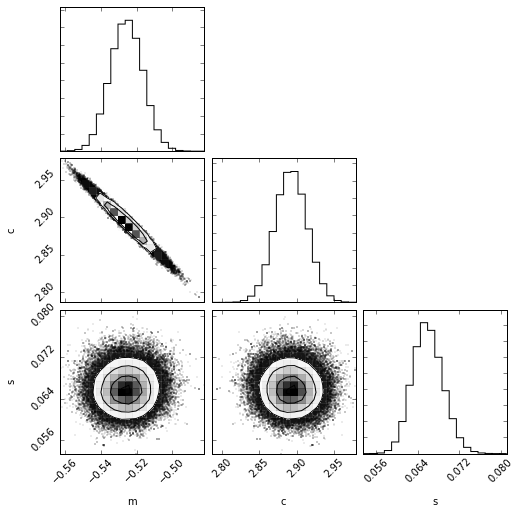

In [14]:
fig = corner.corner(samples, labels=["m", "c", "s"])
#print(sig1[0])
print(1./(ferr**2 + np.exp(2*pars[2])))

Now the analytic errorbar version

In [64]:
def analytic_lnlike(pars, x, y, xerr, yerr):
    m, b, lns = pars
    sig2 = (m*xerr)**2 + (yerr**2 + np.exp(2*lns))
    ll = -.5 * np.sum((m*x-y+b)**2/sig2 + np.log(sig2))
    return ll

In [65]:
def analytic_lnprob(pars, x, y, xerr, yerr):
    return lnprior(pars) + analytic_lnlike(pars, x, y, xerr, yerr)

In [1]:
pars_init = [m, c, np.log(3)]
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, analytic_lnprob, args=(r, f, rerr, ferr))
sampler.run_mcmc(pos, 10000)  # run MCMC
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
samples[:, 2] = np.exp(samples[:, 2])
m2, c2, ln_sig2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

NameError: name 'm' is not defined

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


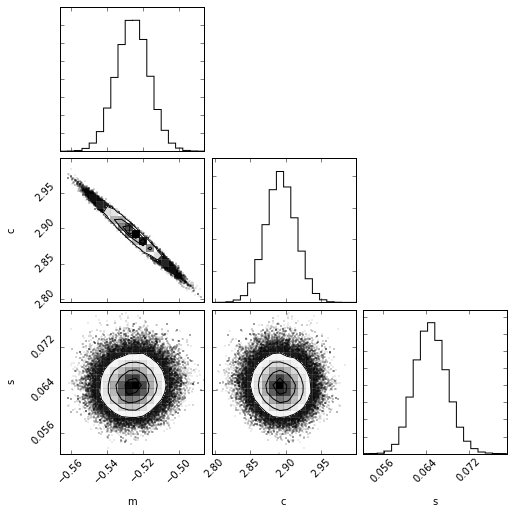

In [67]:
fig = corner.corner(samples, labels=["m", "c", "s"])

The results are pretty consistent!

In [70]:
print(m1)
print(m2)

(-0.5258159725512197, 0.0090731739827999425, 0.0089543635094284646)
(-0.5259104938032606, 0.0090467602791546309, 0.0092209646195137163)


In [71]:
print(c1)
print(c2)

(2.8926709199158118, 0.020586390818707834, 0.021119869789921086)
(2.8928024800886094, 0.021334203811620434, 0.020830292423211993)


In [72]:
print(ln_sig1)
print(ln_sig2)

(0.065834708552257759, 0.0029687165867213205, 0.0028283684968004597)
(0.064879262447680691, 0.0030670117905692573, 0.0028747967348606296)
